# [**Régression à amplification de gradient**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_11_ensembles/plot_gradient_boosting_regression.ipynb)<br/>([*Gradient Boosting regression*](https://scikit-learn.org/stable/auto_examples/ensembles/plot_gradient_boosting_regression.html))

Cet exemple montre Gradient Boosting pour produire un modèle prédictif à partir d'un ensemble de modèles prédictifs faibles. L'amplification du gradient peut être utilisée pour les problèmes de régression et de classification. Ici, nous allons entraîner un modèle pour nous attaquer à une tâche de régression du diabète. Nous obtiendrons les résultats de [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) avec la perte des moindres carrés et 500 arbres de régression de profondeur 4.

Remarque : Pour les ensembles de données plus volumineux (`n_samples >= 10 000`), veuillez consulter [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html).

In [1]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Maria Telenczuk <https://github.com/maikia>
#         Katrina Ni <https://github.com/nilichen>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Charger les données

Nous devons d'abord charger les données.

In [2]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

# Prétraitement des données

Ensuite, nous allons diviser notre ensemble de données pour en utiliser 90 % pour l'entraînement et laisser le reste pour les tests. Nous fixerons également les paramètres du modèle de régression. Vous pouvez jouer avec ces paramètres pour voir comment les résultats évoluent.

`n_estimators` : le nombre d'étages de boosting qui seront effectués. Plus tard, nous tracerons la déviance par rapport aux itérations de boosting.

`max_depth` : limite le nombre de nœuds dans l'arbre. La meilleure valeur dépend de l'interaction des variables d'entrée.

`min_samples_split` : le nombre minimum d'échantillons requis pour diviser un nœud interne.

`learning_rate` : de combien la contribution de chaque arbre diminuera.

`loss` : fonction de perte à optimiser. La fonction des moindres carrés est utilisée dans ce cas cependant, il existe de nombreuses autres options (voir [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)).

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

# Ajuster le modèle de régression

Maintenant, nous allons initier les régresseurs à amplification de gradient et les adapter à nos données d'entraînement. Regardons également l'erreur quadratique moyenne sur les données de test.

In [4]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3038.9411


# Tracer la déviance d'entraînement

Enfin, nous allons visualiser les résultats. Pour ce faire, nous allons d'abord calculer la déviance de l'ensemble de test, puis la tracer par rapport aux itérations d'amplification.

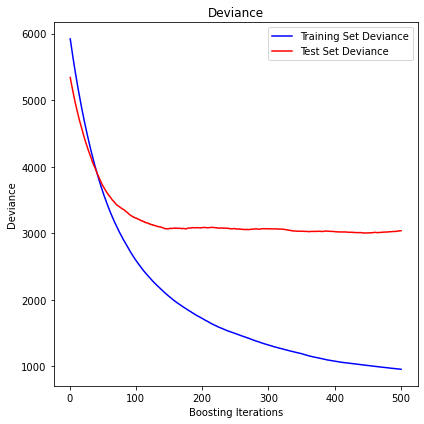

In [7]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)  # reg.loss_ : depr 1.1 and rmv 1.3

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

# Tracer l'importance des caractéristiques

**Avertissement** - L'importance des caractéristiques prudentes et basées sur les impuretés peut être trompeuse pour les **caractéristiques à cardinalité élevée** (nombreuses valeurs uniques). Comme alternative, les importances de permutation de `reg` peuvent être calculées sur un jeu de test retenu. Voir [**Importance des caractéristiques par permutation** (4.2)](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance) pour plus de détails.

Pour cet exemple, les méthodes basées sur les impuretés et par permutation identifient les 2 mêmes caractéristiques fortement prédictives mais pas dans le même ordre. La troisième caractéristique la plus prédictive, “bp”, est également la même pour les 2 méthodes. Les caractéristiques restantes sont moins prédictives et les barres d'erreur du diagramme de permutation montrent qu'elles se chevauchent avec 0.

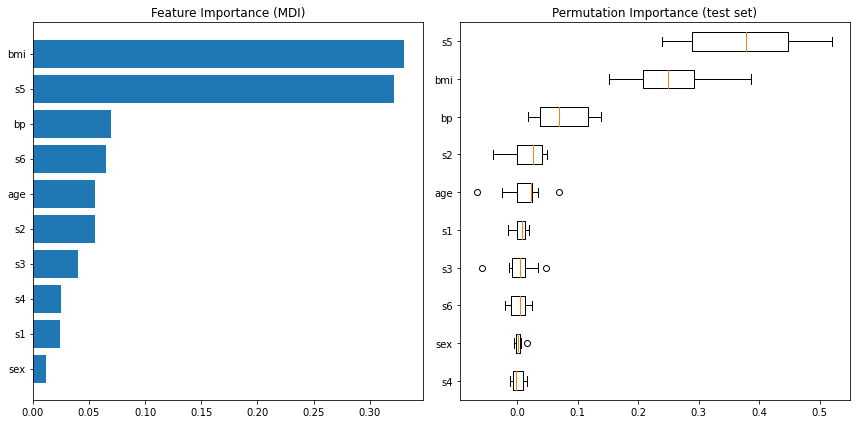

In [6]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(diabetes.feature_names)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()